In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model, model_selection, pipeline, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import RandomizedSearchCV

X = pd.read_csv('X.csv')
y = pd.read_csv('y.csv')
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

y_train_count = y_train['Final colony count'].ravel()
y_test_count = y_test['Final colony count'].ravel()
y_train_log = y_train['Log final to initial'].ravel()
y_test_log = y_test['Log final to initial'].ravel()

### Linear regression baseline

In [7]:
# Set up model
lr_baseline = linear_model.Ridge(fit_intercept=False, max_iter=500, random_state=42)
lr_params = {"model__alpha": np.logspace(start=-4, stop=4, num=10)}

# Set up pipeline
lr_pipeline = pipeline.Pipeline(steps=[("model", lr_baseline)])

cross_validator = model_selection.StratifiedShuffleSplit(train_size=0.8, random_state=42, n_splits=30)

lr_baseline_grid = model_selection.GridSearchCV(
                        estimator=lr_pipeline,
                        param_grid=lr_params,
                        refit=True,
                        scoring='neg_mean_absolute_error',
                        n_jobs=-1,
                        verbose=1
                    )

Evaluate on the training data
For the baseline, use a vector of 1's (intercept)

In [11]:
X_train_generic = np.ones(shape=y_train_count.shape[0]).reshape(-1, 1)

lr_base_mod = lr_baseline_grid.fit(X_train_generic, y_train_count)
lr_base_best_estimator = lr_base_mod.best_estimator_

lr_cv_scores = model_selection.cross_val_score(
                    lr_base_best_estimator,
                    X_train_generic,
                    y_train_count,
                    scoring='neg_mean_absolute_error',
                    cv=cross_validator,
                    n_jobs=-1
                )

sns.histplot(lr_cv_scores)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

Run on the test predictions

In [ ]:
lr_base_test_pred = lr_base_best_estimator.predict(X_train_generic)

In [2]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, y_train)
y_train_pred = lr_model.predict(X_train)
print("Results on the training data")
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(y_train, y_train_pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(y_train, y_train_pred))
print('Explained variance score: %.2f'
      % explained_variance_score(y_train, y_train_pred))

# Now run the model on the testing data and check results
y_test_pred = lr_model.predict(X_test)
print()
print("Results on the testing data")
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(y_test, y_test_pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(y_test, y_test_pred))
print('Explained variance score: %.2f'
      % explained_variance_score(y_test, y_test_pred))

Results on the training data
Mean squared error (MSE): 0.01
Coefficient of determination (R^2): 0.35
Explained variance score: 0.35

Results on the testing data
Mean squared error (MSE): 0.02
Coefficient of determination (R^2): 0.07
Explained variance score: 0.08


Based on what I read, the best value for explained variance and R^2 is one. So, these results seem pretty bad by those metrics. Whereas, the mean squared error is better if it's lower, so this model works fairly well by that measure.

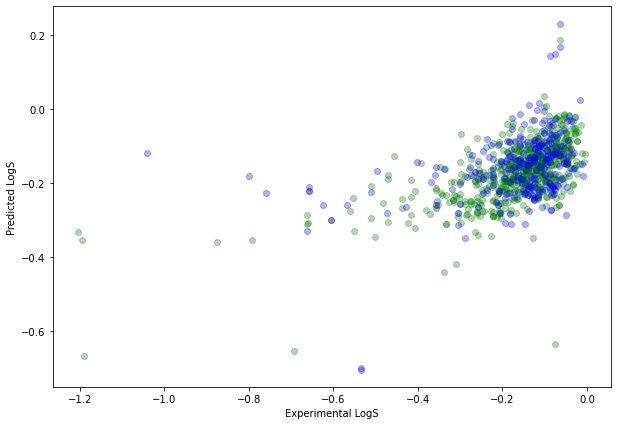

In [3]:
# Scatter plot of the train and test set results
plt.figure(figsize=(10,7))

# plt.subplot(2, 1, 1)
plt.scatter(x=y_train, y=y_train_pred, c="green", alpha=0.3)

# plt.subplot(2, 1, 2)
plt.scatter(x=y_test, y=y_test_pred, c="blue", alpha=0.3)

plt.ylabel('Predicted LogS')
plt.xlabel('Experimental LogS')

plt.show()

In [9]:
regr = svm.SVC()
tuned_parameters = [{
    'kernel': ['rbf'], 
    'gamma': [1e-4,1e-3,1e-2,1e-1,1e+0,1e+1,1e+2,1e+3,1e+4],
    'C': [1e+0,1e+1,1e+2,1e+3,1e+4,1e+5,1e+6,1e+7,1e+8,1e+9]
}]

# I get an error on the fit here about the continuous variable. What should I be using instead,
# since the Y variable is not the classification class.
RSCV = RandomizedSearchCV(estimator=regr, param_distributions=tuned_parameters)
RSresult = RSCV.fit(X_train, y_train)

best_model = RSresult.best_estimator_
yhat = best_model.predict(X_test)
print(yhat)

/Users/tgreen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tgreen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tgreen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tgreen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expec

ValueError: Unknown label type: 'continuous'

Random Forest Regressor

/var/folders/zc/yl2hq8l525d4gr4r1b96z5jr0000gp/T/ipykernel_87684/4140609140.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)



Results on the testing data with Random Forest
Mean squared error (MSE): 0.00
Coefficient of determination (R^2): 0.88
Explained variance score: 0.88


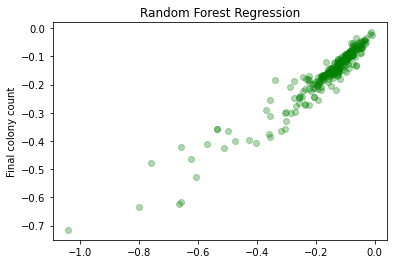

In [10]:
rf_model = RandomForestRegressor(
    n_estimators=100, random_state=42, max_depth=10, bootstrap = True, max_features ='auto'
)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

print()
print("Results on the testing data with Random Forest")
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(y_test, rf_predictions))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(y_test, rf_predictions))
print('Explained variance score: %.2f'
      % explained_variance_score(y_test, rf_predictions))

plt.scatter(y_test, rf_predictions, color='green', alpha=0.3)
plt.title('Random Forest Regression')
plt.ylabel('Final colony count')
plt.show()

# I tweaked the max_depth and max_features params to get an MSE of 0 and a higher explained variance and R^2 than with 
# max_features of sqrt and no max_depth set. 

Bayesian model

I tried to use PyMC3 and installed it with 'conda install' but it still didn't work. So, I switched to sklearn's Bayesian Ridge regression instead


Results on the testing data with Random Forest
Mean squared error (MSE): 0.02
Coefficient of determination (R^2): 0.10
Explained variance score: 0.10


/Users/tgreen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


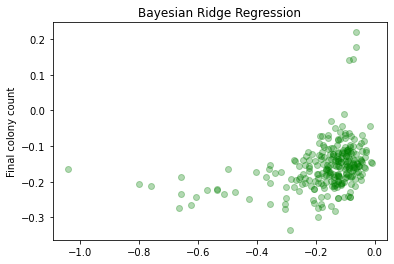

In [11]:
br_model = linear_model.BayesianRidge(n_iter=1000, tol=0.0001)
br_model.fit(X_train, y_train)
y_br_pred = br_model.predict(X_test)

print()
print("Results on the testing data with Random Forest")
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(y_test, y_br_pred))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(y_test, y_br_pred))
print('Explained variance score: %.2f'
      % explained_variance_score(y_test, y_br_pred))

plt.scatter(y_test, y_br_pred, color='green', alpha=0.3)
plt.title('Bayesian Ridge Regression')
plt.ylabel('Final colony count')
plt.show()